# Model 1: Predictive Deep Learning Model

**Goal**: Train a Multi-Layer Perceptron (MLP) to predict probability of loan default.

**Key Approaches**:
*   **Architecture**: MLP with Batch Normalization and Dropout.
*   **Loss**: `BCEWithLogitsLoss` for stability.
*   **Imbalance Handling**: Optional `pos_weight`.
*   **Evaluation**: AUC-ROC and Optimized F1-Score.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, precision_recall_curve, confusion_matrix, classification_report

# Configuration
PROCESSED_DATA_DIR = Path("data/processed")
MODEL_SAVE_PATH = Path("models/mlp_model.pth")
MODEL_SAVE_PATH.parent.mkdir(parents=True, exist_ok=True)

BATCH_SIZE = 1024  
EPOCHS = 20
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")

Using device: cuda


## 1. Load Processed Data

In [2]:
print("Loading data...")
X_train = pd.read_parquet(PROCESSED_DATA_DIR / "X_train.parquet")
X_test = pd.read_parquet(PROCESSED_DATA_DIR / "X_test.parquet")
y_train = pd.read_parquet(PROCESSED_DATA_DIR / "y_train.parquet")
y_test = pd.read_parquet(PROCESSED_DATA_DIR / "y_test.parquet")

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

Loading data...
X_train shape: (1076280, 175)
y_train shape: (1076280, 1)


In [3]:
# Convert to Numpy/Tensor
class LoanDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values)
        self.y = torch.FloatTensor(y.values)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = LoanDataset(X_train, y_train)
test_dataset = LoanDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

input_dim = X_train.shape[1]
print(f"Input Dimension: {input_dim}")

Input Dimension: 175


## 2. Model Architecture (MLP)

In [4]:
class LoanMLP(nn.Module):
    def __init__(self, input_dim):
        super(LoanMLP, self).__init__()
        self.model = nn.Sequential(
            # Layer 1
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            # Layer 2
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            # Layer 3
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            # Output Layer (logits)
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.model(x)

## 3. Training Loop

In [5]:
model = LoanMLP(input_dim).to(DEVICE)

# Calculate class imbalance for optional weighting
neg, pos = np.bincount(y_train['target'])
pos_weight_val = neg / pos
print(f"Class Imbalance: Neg={neg}, Pos={pos}, Ratio={pos_weight_val:.2f}")

# Using standard BCEWithLogitsLoss initially. 
# If F1 is low, could uncomment: pos_weight=torch.tensor(pos_weight_val).to(DEVICE)
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

history = {'train_loss': [], 'val_auc': []}

Class Imbalance: Neg=861401, Pos=214879, Ratio=4.01


In [6]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
        
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    all_probs = []
    all_targets = []
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(DEVICE)
            logits = model(X_batch)
            probs = torch.sigmoid(logits)
            
            all_probs.append(probs.cpu().numpy())
            all_targets.append(y_batch.numpy())
            
    y_true = np.concatenate(all_targets)
    y_scores = np.concatenate(all_probs)
    
    auc = roc_auc_score(y_true, y_scores)
    return auc, y_true, y_scores

In [7]:
print("Starting training...")
best_auc = 0
patience = 5
no_improve = 0

for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    val_auc, _, _ = evaluate(model, test_loader)
    
    history['train_loss'].append(train_loss)
    history['val_auc'].append(val_auc)
    
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {train_loss:.4f} - Val AUC: {val_auc:.4f}")
    
    # Checkpoint
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping!")
            break

# Load best model
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
print("Training complete.")

Starting training...
Epoch 1/20 - Loss: 0.2371 - Val AUC: 0.9519
Epoch 2/20 - Loss: 0.2223 - Val AUC: 0.9524
Epoch 3/20 - Loss: 0.2203 - Val AUC: 0.9526
Epoch 4/20 - Loss: 0.2194 - Val AUC: 0.9528
Epoch 5/20 - Loss: 0.2188 - Val AUC: 0.9534
Epoch 6/20 - Loss: 0.2180 - Val AUC: 0.9534
Epoch 7/20 - Loss: 0.2173 - Val AUC: 0.9535
Epoch 8/20 - Loss: 0.2167 - Val AUC: 0.9536
Epoch 9/20 - Loss: 0.2163 - Val AUC: 0.9537
Epoch 10/20 - Loss: 0.2158 - Val AUC: 0.9536
Epoch 11/20 - Loss: 0.2152 - Val AUC: 0.9538
Epoch 12/20 - Loss: 0.2151 - Val AUC: 0.9539
Epoch 13/20 - Loss: 0.2148 - Val AUC: 0.9539
Epoch 14/20 - Loss: 0.2141 - Val AUC: 0.9540
Epoch 15/20 - Loss: 0.2140 - Val AUC: 0.9541
Epoch 16/20 - Loss: 0.2134 - Val AUC: 0.9542
Epoch 17/20 - Loss: 0.2132 - Val AUC: 0.9542
Epoch 18/20 - Loss: 0.2126 - Val AUC: 0.9542
Epoch 19/20 - Loss: 0.2125 - Val AUC: 0.9541
Epoch 20/20 - Loss: 0.2121 - Val AUC: 0.9542
Training complete.


## 4. Evaluation & Threshold Tuning

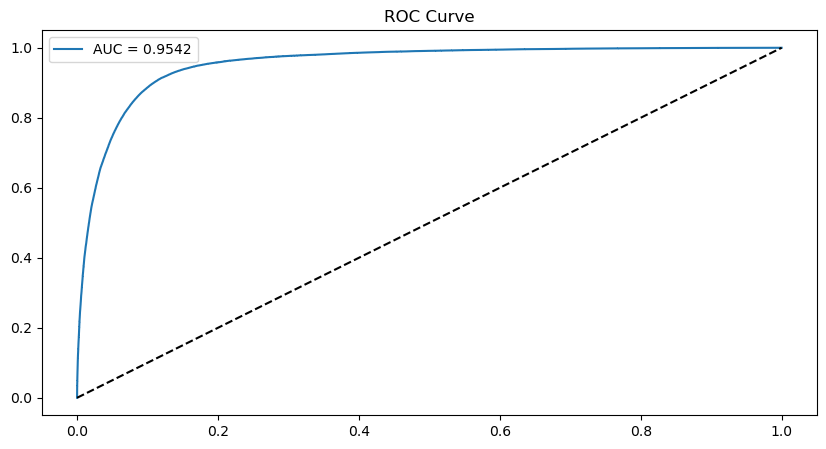

Best F1-Score: 0.7818 at Threshold: 0.3773

Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94    215350
         1.0       0.73      0.84      0.78     53720

    accuracy                           0.91    269070
   macro avg       0.85      0.88      0.86    269070
weighted avg       0.91      0.91      0.91    269070


Classification Report (Default Threshold 0.5):
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94    215350
         1.0       0.78      0.76      0.77     53720

    accuracy                           0.91    269070
   macro avg       0.86      0.85      0.86    269070
weighted avg       0.91      0.91      0.91    269070



In [8]:
auc_score, y_true, y_scores = evaluate(model, test_loader)

# 1. ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.legend()
plt.show()

# 2. Find Optimal F1 Threshold
precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_f1_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_f1_idx]
best_f1 = f1_scores[best_f1_idx]

print(f"Best F1-Score: {best_f1:.4f} at Threshold: {best_threshold:.4f}")

# 3. Metrics at Optimized Threshold
y_pred_opt = (y_scores >= best_threshold).astype(int)
print("\nClassification Report (Optimized Threshold):")
print(classification_report(y_true, y_pred_opt))

# 4. Metrics at Default Threshold
y_pred_def = (y_scores >= 0.5).astype(int)
print("\nClassification Report (Default Threshold 0.5):")
print(classification_report(y_true, y_pred_def))

> [!NOTE]
> This model effectively learns a policy $\pi(a|s)$: "Approve if $P(default|s) < T$". 
> In Task 3, we will compare this with an RL agent that learns a policy to maximize financial return directly.